In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dst import dst

def localtime(hour, longitude, precision):
        return round((hour - (360 - longitude) / 15) % 24, precision)

EXPERIMENTAL_PATH = "datos_ais.csv"
CCIR_PATH = "201401-m3000f2-fof2.csv"
LONGITUDE = 294.6
MONTH = 1

experimental = pd.DataFrame.from_csv(EXPERIMENTAL_PATH)
ccir = pd.DataFrame.from_csv(CCIR_PATH)

ccir.reset_index(inplace=True)
# Renombrar con los mismos nombres de columnas que los datos experimentales
ccir.columns = ["year", "month", "day", "hour", "M(3000)F2 CCIR", "foF2 CCIR"]

#Redondear a 2 decimales la hora
experimental["hour"] = [round(x, 2) for x in experimental["hour"]]

# Se fija un índice compuesto para poder unir ambos dataframes
experimental.set_index(["year", "month", "day", "hour"], inplace=True)
ccir.set_index(["year", "month", "day", "hour"], inplace=True)

# Unir los 2 dataframes
q = ccir
q["foF2"] = experimental["foF2"]
q["M(3000)F2"] = experimental["M(3000)F2"]
q["d foF2"] = q["foF2 CCIR"] - q["foF2"]
q["d M(3000)F2"] = q["M(3000)F2 CCIR"] - q["M(3000)F2"]
q["r foF2"] = q["d foF2"] / q["foF2"]
q["r M(3000)F2"] = q["d M(3000)F2"] / q["M(3000)F2"]

# Se quita el index para facilitar la visualización
q = q.reset_index()

# Agregando LT y dst
q["LT"] = [localtime(hour, LONGITUDE, 2) for hour in q["hour"].values]
q["dst"] = [dst(MONTH, day, hour) for day, hour  in q[["day", "hour"]].values]

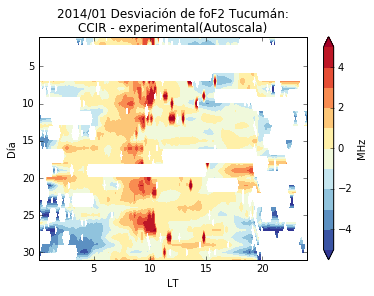

In [2]:
def deviation():
    pivot=q.pivot('day', 'LT', 'd foF2')
    levels = np.arange(-5, 5 + 1, 1)
    X=pivot.columns.values
    Y=pivot.index.values
    Z=pivot.values
    x,y=np.meshgrid(X, Y)
    plt.gca().invert_yaxis()
    cf = plt.contourf(x, y, Z, cmap=plt.cm.RdYlBu_r, levels=levels, interpolation=None, extend='both')
    plt.colorbar(cf, label="MHz")
    plt.xlabel("LT")
    plt.ylabel("Día")
    plt.title("2014/01 Desviación de foF2 Tucumán:\nCCIR - experimental(Autoscala)")
    plt.show()
    
deviation()

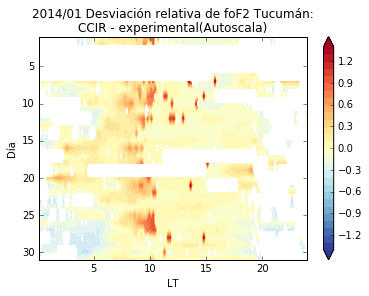

In [3]:
def relative_deviation():
    pivot=q.pivot('day', 'LT', 'r foF2')
    levels = np.arange(-1.4, 1.4 + 0.1, 0.1)
    X=pivot.columns.values
    Y=pivot.index.values
    Z=pivot.values
    x,y=np.meshgrid(X, Y)
    plt.gca().invert_yaxis()
    cf = plt.contourf(x, y, Z, cmap=plt.cm.RdYlBu_r, levels=levels, interpolation=None, extend='both')
    plt.colorbar(cf)
    plt.xlabel("LT")
    plt.ylabel("Día")
    plt.title("2014/01 Desviación relativa de foF2 Tucumán:\nCCIR - experimental(Autoscala)")
    plt.show()
relative_deviation()


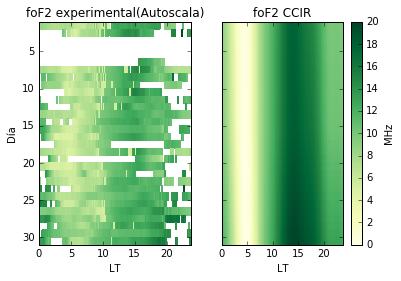

In [4]:
def comparison():
    pivot=q.pivot('day', 'LT', 'foF2')
    pivot2=q.pivot('day', 'LT', 'foF2 CCIR')
    levels = np.arange(0, 15 + 0.5, 0.5)
    X=pivot.columns.values
    Y=pivot.index.values
    Z=pivot.values
    Z2=pivot2.values
    x,y=np.meshgrid(X, Y)
    Z = np.ma.array(Z, mask=np.isnan(Z))

    f, axarr = plt.subplots(1, 2, sharey=True)
    
    cf = axarr[0].pcolormesh(x, y, Z, cmap=plt.cm.YlGn, vmin=0, vmax=20)

    axarr[0].set_xlabel("LT")
    axarr[0].set_ylabel("Día")
    axarr[0].set_title("foF2 experimental(Autoscala)")

    cf2 = axarr[1].pcolormesh(x, y, Z2, cmap=plt.cm.YlGn, )
                    #levels=levels, extend='max')
    axarr[1].set_xlabel("LT")
    axarr[1].set_title("foF2 CCIR")
    
    axarr[0].set_xlim(0,23.83)
    axarr[0].set_ylim(1,31)
    
    axarr[1].set_xlim(0,23.83)
    axarr[1].set_ylim(1,31)
    plt.gca().invert_yaxis()
    plt.colorbar(cf, label="MHz")

    plt.show()


comparison()

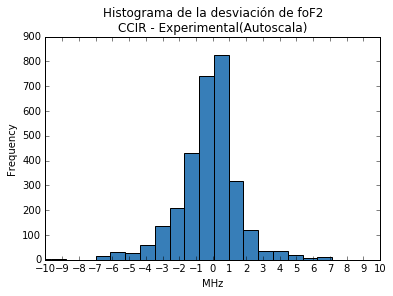

In [5]:
def deviation_hist():
    q["d foF2"].plot.hist(bins=20, color="#377eb8")
    plt.xticks(range(-10, 10+1))
    plt.xlim(-10,10)
    plt.title("Histograma de la desviación de foF2\nCCIR - Experimental(Autoscala)")
    plt.xlabel("MHz")
    plt.show()

deviation_hist()

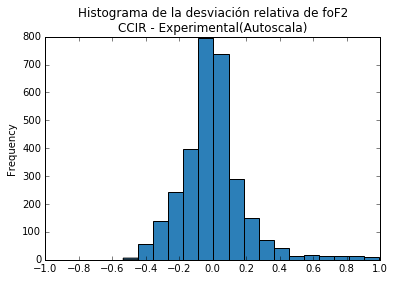

In [6]:
def relative_deviation_hist():
    q["r foF2"].plot.hist(bins=21, color="#2c7fb8")
    plt.xticks(np.arange(-1, 1+0.2, 0.2))
    plt.xlim(-1,1)
    plt.title("Histograma de la desviación relativa de foF2\nCCIR - Experimental(Autoscala)")
    plt.xlabel("")
    plt.show()
relative_deviation_hist()

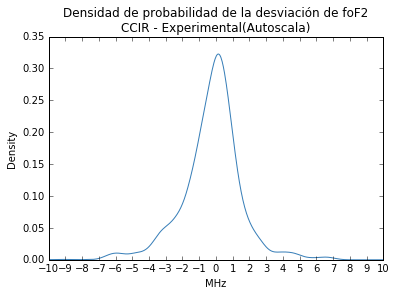

In [7]:
def density():
    q["d foF2"].plot.density(color="#377eb8")
    plt.xticks(range(-10, 10+1))
    plt.xlim(-10,10)
    plt.title("Densidad de probabilidad de la desviación de foF2\nCCIR - Experimental(Autoscala)")
    plt.xlabel("MHz")
    plt.show()

density()

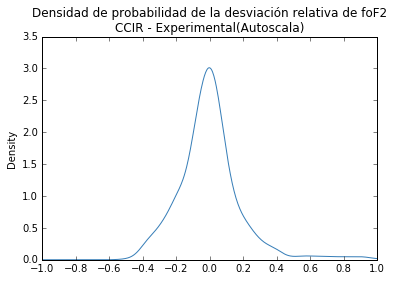

In [8]:
def density_relative():
    q["r foF2"].plot.density(color="#377eb8")
    plt.xticks(np.arange(-1, 1 + 0.2, 0.2))
    plt.xlim(-1,1)
    plt.title("Densidad de probabilidad de la desviación relativa de foF2\nCCIR - Experimental(Autoscala)")
    plt.xlabel("")
    plt.show()
    
density_relative()

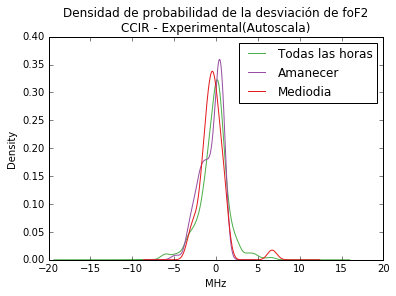

In [9]:
AMANECER = q["LT"].between(4,6)
MEDIODIA = q["LT"].between(14,16)
def density_timeslots():
    q["d foF2"].plot.density(label="Todas las horas", color="#4daf4a")
    q[AMANECER]["d foF2"].plot.density(label="Amanecer", color="#984ea3")
    q[MEDIODIA]["d foF2"].plot.density(label="Mediodia", color="#e41a1c")
    plt.title("Densidad de probabilidad de la desviación de foF2\nCCIR - Experimental(Autoscala)")
    plt.xlabel("MHz")
    plt.legend()
    plt.show()

density_timeslots()

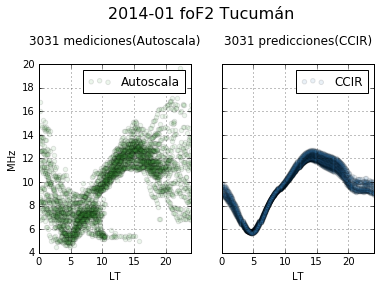

In [19]:
def comparison2():
    f, axarr = plt.subplots(1, 2, sharey=True)
    q.plot.scatter(x="LT", y="foF2", alpha=0.1, ax=axarr[0], label="Autoscala", color="#4daf4a")
    q[q["foF2"].notnull()].plot.scatter(x="LT", y="foF2 CCIR", alpha=0.1,
                                        ax=axarr[1], label="CCIR", color="#377eb8")
    
    plt.ylim(4, 20)
    axarr[0].set_xlim(0, 24)
    axarr[1].set_xlim(0, 24)
    axarr[0].set_ylabel("MHz")
    plt.legend(loc=0)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title("%s mediciones(Autoscala)\n"%len(q[q["foF2"].notnull()]))
    axarr[1].set_title("%s predicciones(CCIR)\n"%len(q[q["foF2"].notnull()]))
    f.suptitle("2014-01 foF2 Tucumán", fontsize=16)
    f.subplots_adjust(top=0.78)

    plt.show()

comparison2()

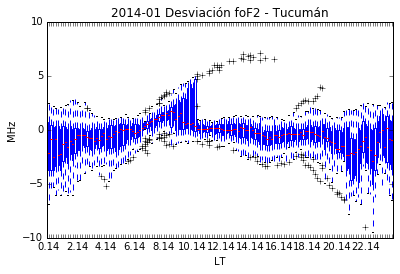

In [20]:

def box_plot_lt():
    ax = q.boxplot(column="d foF2", by="LT")
    ax.set_ylim(-10, 10)
    ax.set_xticklabels([x if i%12==0 else '' for i, x in enumerate(np.unique(q["LT"])) ])
    ax.set_ylabel("MHz")
    plt.title("2014-01 Desviación foF2 - Tucumán")
    plt.suptitle("")
    plt.grid(False)
    plt.show()
box_plot_lt()

In [21]:
MADRUGADA = (0,6)
MANIANA = (6,12)
TARDE = (12,18)
NOCHE = (18,24)

def franja(LT):
    if 0 <= LT < 6:
        return "Madrugada"
    if 6 <= LT < 12:
        return "Mañana"
    if 12 <= LT < 18:
        return "Tarde"
    if 18 <= LT < 24:
        return "Noche"

q["franja"] = [franja(LT) for LT in q["LT"].values]

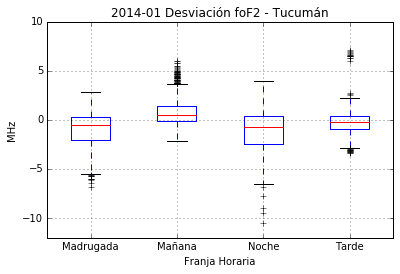

In [22]:
def box_plot_franja():
    ax = q.boxplot(column="d foF2", by="franja", return_type='dict')
    plt.ylim(-12, 10)
    plt.xlabel("Franja Horaria")
    plt.ylabel("MHz")
    plt.title("2014-01 Desviación foF2 - Tucumán")
    plt.suptitle("")
    plt.show()
box_plot_franja()

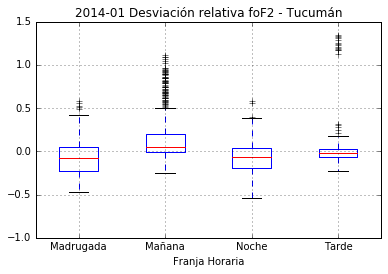

In [23]:
def relative_box_plot_franja():
    ax = q.boxplot(column="r foF2", by="franja")
    ax.set_ylim(-1, 1.5)
    ax.set_xlabel("Franja Horaria")
    ax.set_ylabel("")
    plt.title("2014-01 Desviación relativa foF2 - Tucumán")
    plt.suptitle("")
    plt.show()
relative_box_plot_franja()

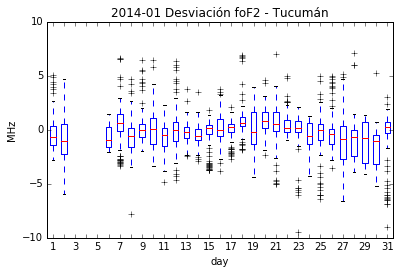

In [24]:
def box_plot_day():
    ax = q.boxplot(column="d foF2", by="day")
    ax.set_ylim(-10, 10)
    ax.set_xticklabels([int(x) if i%2==0 else '' for i, x in enumerate(np.unique(q["day"])) ])
    ax.set_ylabel("MHz")
    plt.title("2014-01 Desviación foF2 - Tucumán")
    plt.suptitle("")
    plt.grid(False)
    plt.show()
box_plot_day()

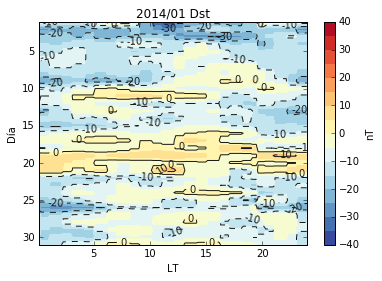

In [28]:
def dst():
    pivot=q.pivot('day', 'LT', 'dst')
    levels = np.arange(-40, 40 + 5, 5)
    X=pivot.columns.values
    Y=pivot.index.values
    Z=pivot.values
    x,y=np.meshgrid(X, Y)
    plt.gca().invert_yaxis()
    c = plt.contour(x, y, Z, levels=levels[::2], colors='0.1')
    plt.clabel(c, inline=1, fontsize=10, fmt='%1.0f')
    cf = plt.contourf(x, y, Z, cmap=plt.cm.RdYlBu_r, levels=levels)
    plt.colorbar(cf, label="nT")
    plt.xlabel("LT")
    plt.ylabel("Día")
    plt.title("2014/01 Dst")
    plt.show()
    
dst()